In [ ]:
# ..... differential abundance test with Milo ..... #

In [2]:
library(Seurat)
library(SingleCellExperiment)
library(dplyr)
library(miloR)
library(scater)
library(patchwork)

In [3]:
# get list of samples
stages = c(rep('stage23', 2), rep(c('stage28', 'stage32'), each = 3))
samples = c('sample3', 'sample10', 'sample5', 'sample10', 'sample11',
           'sample5', 'sample10', 'sample12')

In [4]:
# load data
get_seurat_obj <- function(id1, stages, samples){
    currstage1 = stages[id1]
    currsmp1 = samples[id1]
    sc1 = readRDS(paste0(currstage1, '_', currsmp1, '_data.rds'))

    df1 = read.delim(paste0(currstage1, '_', currsmp1, '_Knight-Schrijver_celltypes.csv'), sep = ',')    
    sc1$celltype = df1$celltype[match(rownames(sc1@meta.data), df1$barcode)]
    sc1$stage <- sc1$orig.ident
    sc1 <- sc1[,!is.na(sc1$celltype) & sc1$celltype!='unassigned']
    return(sc1)
}

In [57]:
# load individual sample files
sce1 = get_seurat_obj(1, stages, samples)
sce2 = get_seurat_obj(2, stages, samples)
sce3 = get_seurat_obj(3, stages, samples)
sce4 = get_seurat_obj(4, stages, samples)
sce1

An object of class Seurat 
17007 features across 8453 samples within 1 assay 
Active assay: RNA (17007 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [58]:
# get metadata
cols = c('stage', 'sample', 'celltype')
mtd1 = sce1@meta.data[,cols]
mtd2 = sce2@meta.data[,cols]
mtd3 = sce3@meta.data[,cols]
mtd4 = sce4@meta.data[,cols]
mtd0 = rbind(mtd1, mtd2, mtd3, mtd4)

In [59]:
# make SCE object
sce = SingleCellExperiment(list(counts = cbind(GetAssayData(sce1, 'counts'),
                                               GetAssayData(sce2, 'counts'),
                                               GetAssayData(sce3, 'counts'),
                                               GetAssayData(sce4, 'counts'))),
                           colData = DataFrame(mtd0))
sce

class: SingleCellExperiment 
dim: 17007 40402 
metadata(0):
assays(1): counts
rownames(17007): SPRY2 PCDH20 ... ENSGALG00010000495 ENSGALG00010000377
rowData names(0):
colnames(40402): stage23_sample3_AAACCCAAGTAACAGT-1
  stage23_sample3_AAACCCACAACAGAGC-1 ...
  stage28_sample10_TTTGTTGGTTAGTCGT-1
  stage28_sample10_TTTGTTGTCGCACGGT-1
colData names(3): stage sample celltype
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [60]:
# prune sce data
common_celltypes = sort(intersect(intersect(intersect(mtd1$celltype, mtd2$celltype), mtd3$celltype), mtd4$celltype))
sce <- sce[,sce$celltype %in% common_celltypes]
dim(sce)

[1] 17007 40358

In [61]:
logcounts(sce) <- log(counts(sce) + 1)
sce <- runPCA(sce, ncomponents=30)
sce <- runUMAP(sce)
sce

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.1 GiB”


class: SingleCellExperiment 
dim: 17007 40358 
metadata(0):
assays(2): counts logcounts
rownames(17007): SPRY2 PCDH20 ... ENSGALG00010000495 ENSGALG00010000377
rowData names(0):
colnames(40358): stage23_sample3_AAACCCAAGTAACAGT-1
  stage23_sample3_AAACCCACAACAGAGC-1 ...
  stage28_sample10_TTTGTTGGTTAGTCGT-1
  stage28_sample10_TTTGTTGTCGCACGGT-1
colData names(3): stage sample celltype
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):

In [62]:
embryo_milo <- Milo(sce)
reducedDim(embryo_milo, "UMAP") <- reducedDim(sce, "UMAP")

In [69]:
embryo_milo$sample <- paste0(embryo_milo$stage, '_', embryo_milo$sample)

In [70]:
embryo_milo

class: Milo 
dim: 17007 40358 
metadata(0):
assays(2): counts logcounts
rownames(17007): SPRY2 PCDH20 ... ENSGALG00010000495 ENSGALG00010000377
rowData names(0):
colnames(40358): stage23_sample3_AAACCCAAGTAACAGT-1
  stage23_sample3_AAACCCACAACAGAGC-1 ...
  stage28_sample10_TTTGTTGGTTAGTCGT-1
  stage28_sample10_TTTGTTGTCGCACGGT-1
colData names(3): stage sample celltype
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 40358 3436
nhoodCounts dimensions(2): 3436 3
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 3436
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1

In [71]:
embryo_milo <- buildGraph(embryo_milo, k = 10, d = 30)

Constructing kNN graph with k:10



In [72]:
embryo_milo <- makeNhoods(embryo_milo, prop = 0.1, k = 10, d=30, refined = TRUE)

Checking valid object

Running refined sampling with reduced_dim



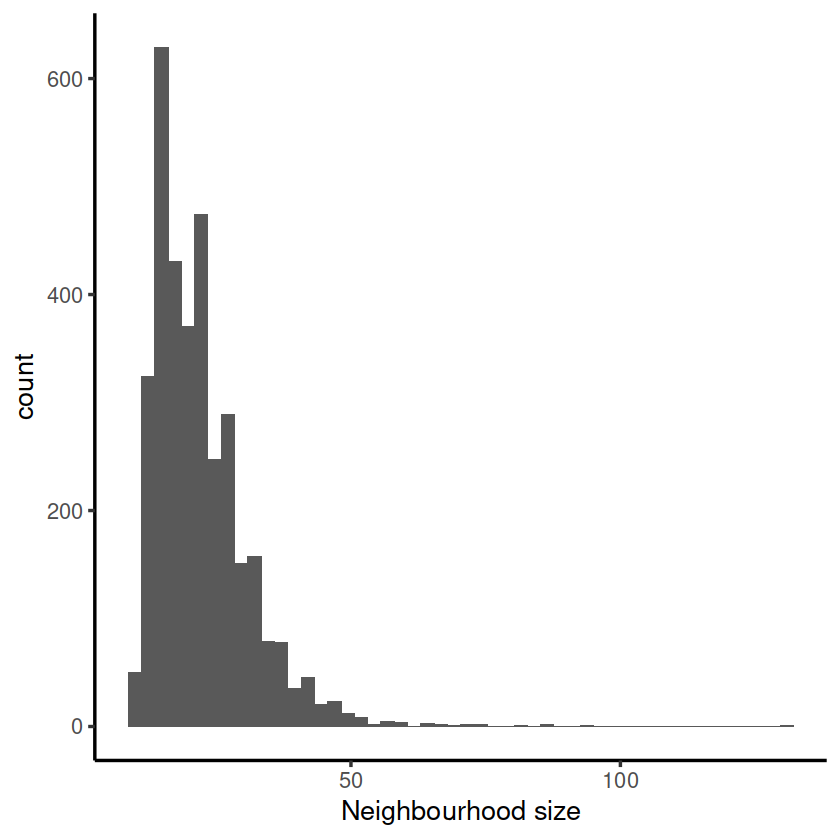

In [73]:
plotNhoodSizeHist(embryo_milo)

In [74]:
embryo_milo <- countCells(embryo_milo, meta.data = data.frame(colData(embryo_milo)), samples="sample")

Checking meta.data validity

Counting cells in neighbourhoods



In [75]:
embryo_design <- data.frame(colData(embryo_milo))[,c("stage", "sample")]
embryo_design <- distinct(embryo_design)
rownames(embryo_design) <- embryo_design$sample

## Reorder rownames to match columns of nhoodCounts(milo)
embryo_design <- embryo_design[colnames(nhoodCounts(embryo_milo)), , drop=FALSE]

embryo_design

stage   sample          
stage23_sample3  stage23 stage23_sample3 
stage23_sample10 stage23 stage23_sample10
stage28_sample5  stage28 stage28_sample5 
stage28_sample10 stage28 stage28_sample10

In [76]:
embryo_milo <- calcNhoodDistance(embryo_milo, d=30)
rownames(embryo_design) <- embryo_design$sample

In [79]:
da_results <- testNhoods(embryo_milo, design = ~ stage, design.df = embryo_design)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [84]:
da_results <- annotateNhoods(embryo_milo, da_results, coldata_col = "celltype")
head(da_results)

Converting celltype to factor...



logFC      logCPM   F          PValue    FDR       Nhood SpatialFDR
1 -0.8560567 8.980676 0.05783886 0.8099521 0.8896233 1     0.8934434 
2  4.1339407 8.570078 1.10503218 0.2932012 0.8136488 2     0.7764735 
3  2.3254288 8.943621 0.39469414 0.5298630 0.8136488 3     0.8074847 
4  1.5820695 8.407528 0.21157636 0.6455492 0.8300781 4     0.8325672 
5  1.7076212 8.562033 0.23051325 0.6311587 0.8287684 5     0.8299132 
6 -3.0649223 8.514251 0.67639378 0.4108597 0.8136488 6     0.7938815 
  celltype       celltype_fraction
1 Cardiomyocytes 0.6785714        
2 Endocardial    0.6818182        
3 Immature_other 0.6785714        
4 Cardiomyocytes 1.0000000        
5 Immature_other 0.6000000        
6 Endocardial    0.5882353

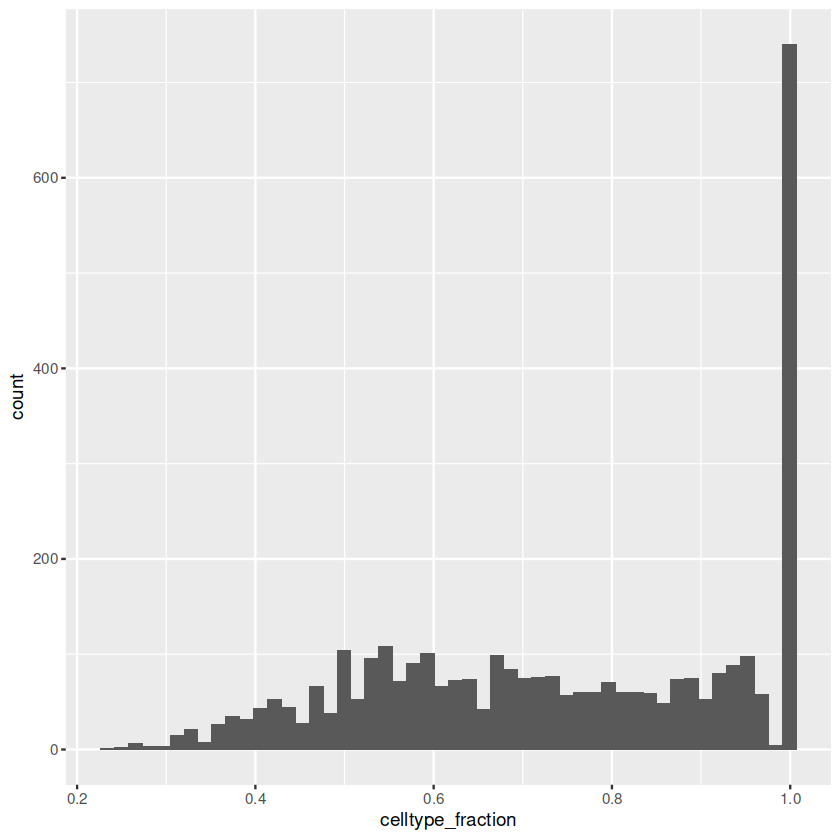

In [89]:
ggplot(da_results, aes(celltype_fraction)) + geom_histogram(bins=50)

In [85]:
da_results %>%
  arrange(- SpatialFDR) %>%
  head() 

logFC        logCPM   F            PValue    FDR       Nhood SpatialFDR
2197  0.004210981 8.599844 1.755286e-06 0.9989429 0.9989429 2197  0.9989429 
160  -0.015250346 9.086709 1.780667e-05 0.9966332 0.9979973  160  0.9983515 
283   0.010474740 8.375092 9.162402e-06 0.9975849 0.9979973  283  0.9983515 
1516 -0.012966948 9.256315 1.217186e-05 0.9972164 0.9979973 1516  0.9983515 
2254 -0.013290669 8.336421 1.486901e-05 0.9969234 0.9979973 2254  0.9983515 
3272 -0.010326286 9.015202 8.253271e-06 0.9977079 0.9979973 3272  0.9983515 
     celltype       celltype_fraction
2197 Immature_other 0.7500000        
160  Immature_other 0.9000000        
283  Immature_other 0.4210526        
1516 Immature_other 0.6216216        
2254 Immature_other 0.6666667        
3272 Immature_other 0.4333333

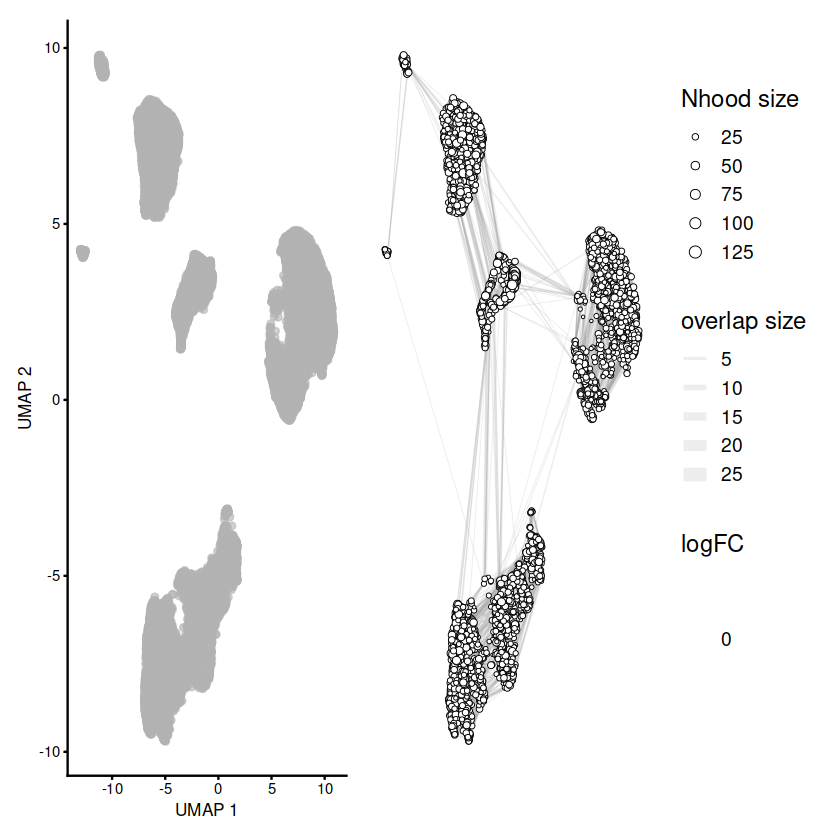

In [86]:
embryo_milo <- buildNhoodGraph(embryo_milo)

plotUMAP(embryo_milo) + plotNhoodGraphDA(embryo_milo, da_results, alpha=0.05) +
  plot_layout(guides="collect")

In [87]:
da_results$celltype <- ifelse(da_results$celltype_fraction < 0.7, "Mixed", da_results$celltype)

In [91]:
table(da_results$celltype)


         Cardiomyocytes             Endocardial             Fibroblasts 
                   1116                     131                      15 
Immature_Cardiomyocytes          Immature_other                   Mixed 
                    131                     560                    1487 
    Smooth_Muscle_Cells 
                      8 

In [93]:
library(ggplot2)

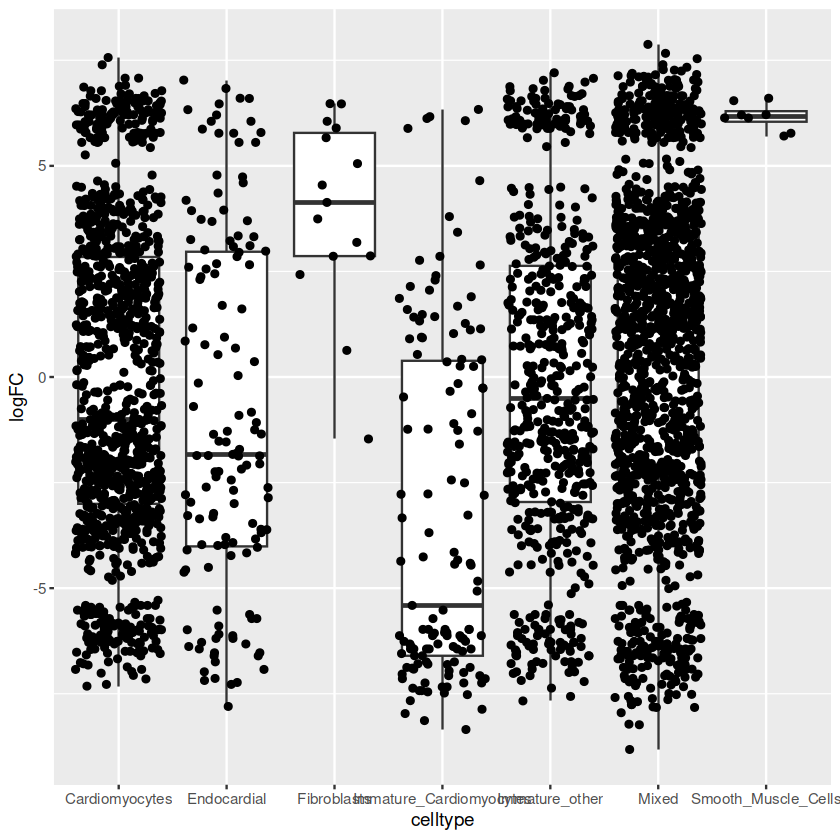

In [96]:
# plotDAbeeswarm(da_results, group.by = "celltype")
ggplot(da_results, aes(x = celltype, y = logFC)) + geom_boxplot() + geom_jitter()